# BERTurk BIO Fine-Tuning (Stage 1 Pretrain on Synth → Stage 2 Finetune on Gold)
This notebook is organized for **two-stage training** on Turkish BIO-tagged address data.

**Stage 1 (Pretrain):**
- Train on large **synthetic CoNLL** data (`synth_group_A2E.conll`, `synth_group_F2J.conll`).
- Recipe: start around **150k** examples, 2–3 epochs, **dropout=0.2**, **weight_decay=0.1**, **label smoothing=0.1**.
- Optionally evaluate on a **tiny gold dev** (~100 samples) if available.

**Stage 2 (Finetune):**
- Load Stage-1 best checkpoint.
- Finetune on **goldset** (e.g., `goldset_1k_yegeb.conll`). With small gold data, apply stronger regularization, smaller LR, and early stopping.

You can toggle/parametrize both stages below. Tokenization is **whole-word aligned** (duplicate labels to all subword pieces). An **optional CRF head** is provided.


## 1. Environment & Installs
Run this cell in **Colab**. It installs needed libraries (safe to re-run).

In [3]:
#@title Install dependencies (Colab-safe)
import sys, subprocess, importlib

def _pip_install(pkg_spec):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_spec])
    except Exception as e:
        print("Install failed:", pkg_spec, e)

# Core
for pkg in [
    "transformers>=4.40.0",
    "datasets>=2.18.0",
    "accelerate>=1.0.0",
    "seqeval>=1.2.2",
    "pytorch-crf>=0.7.2",
    "evaluate>=0.4.0",
]:
    _pip_install(pkg)

import torch, transformers, datasets, seqeval, accelerate
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)

torch: 2.8.0+cu126
transformers: 4.55.2
datasets: 4.0.0


## 2. Global Config (Stage toggles, paths, model, batch sizes)
- **UPLOAD to Colab Files pane** your `.conll` files first.
- Set `USE_CRF`, `RUN_STAGE1`, `RUN_STAGE2` as needed.
- Paths default to `/content/*.conll` for Colab; change if you work locally.


In [8]:
#@title Global switches & paths
from pathlib import Path
import os

# ---- Stage toggles ----
RUN_STAGE1 = True   # Pretrain on synth
RUN_STAGE2 = True  # Finetune on gold (requires Stage1 checkpoint path)

# ---- Optional: use CRF head ----
USE_CRF = False  # set False to use plain token-classification head

# ---- Model base ----
MODEL_NAME = "dbmdz/bert-base-turkish-cased"

# ---- Colab-friendly default paths (upload into /content/) ----
SYNTH_A2E_PATH = Path("/content/synth_group_A2E.conll")
SYNTH_F2J_PATH = Path("/content/synth_group_F2J.conll")
GOLD_FULL_PATH = Path("/content/goldset_1k_yegeb.conll")  # optional for Stage 1 dev & Stage 2 train/dev

# ---- Output dirs ----
STAGE1_OUTDIR = Path("/content/berturk_stage1_out")
STAGE2_OUTDIR = Path("/content/berturk_stage2_out")

STAGE1_BEST = STAGE1_OUTDIR / "best"
STAGE2_BEST = STAGE2_OUTDIR / "best"

os.makedirs(STAGE1_OUTDIR, exist_ok=True)
os.makedirs(STAGE2_OUTDIR, exist_ok=True)

print("Paths:")
print("  Synth A2E:", SYNTH_A2E_PATH, SYNTH_A2E_PATH.exists())
print("  Synth F2J:", SYNTH_F2J_PATH, SYNTH_F2J_PATH.exists())
print("  Gold full:", GOLD_FULL_PATH, GOLD_FULL_PATH.exists())
print("  Stage1 out:", STAGE1_OUTDIR)
print("  Stage2 out:", STAGE2_OUTDIR)

Paths:
  Synth A2E: /content/synth_group_A2E.conll False
  Synth F2J: /content/synth_group_F2J.conll False
  Gold full: /content/goldset_1k_yegeb.conll False
  Stage1 out: /content/berturk_stage1_out
  Stage2 out: /content/berturk_stage2_out


In [23]:
#@title CONFIG — Training hyperparameters
from dataclasses import dataclass
import torch

@dataclass
class TrainCfg:
    output_dir: str
    batch_size: int = 32
    eval_batch_size: int = 32
    epochs: int = 3
    lr: float = 3e-5
    weight_decay: float = 0.10
    warmup_ratio: float = 0.10
    label_smoothing: float = 0.10
    logging_steps: int = 100
    eval_strategy: str = "epoch"
    save_strategy: str = "epoch"
    metric_for_best: str = "f1"
    greater_is_better: bool = True
    grad_accum: int = 1
    fp16: bool = torch.cuda.is_available()
    seed: int = 84
    report_to: list[str] = None

    def __post_init__(self):
        if self.report_to is None:
            self.report_to = ["none"]

STAGE1_CFG = TrainCfg(
    output_dir=str(STAGE1_OUTDIR),
    batch_size=32,
    eval_batch_size=32,
    epochs=3,
    lr=3e-5,
    weight_decay=0.10,
    warmup_ratio=0.10,
    label_smoothing=0.10,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best="f1",
    greater_is_better=True,
    grad_accum=1,
    fp16=torch.cuda.is_available(),
    seed=77,
    report_to=["none"],
)

# Stage 2 config placeholder — tweak when you fine-tune on gold/pseudo

STAGE2_CFG = TrainCfg(
    output_dir=str(STAGE2_OUTDIR),
    batch_size=16,
    eval_batch_size=16,
    epochs=5,
    lr=2e-5,
    weight_decay=0.10,
    warmup_ratio=0.10,
    label_smoothing=0.05,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best="f1",
    greater_is_better=True,
    grad_accum=1,
    fp16=torch.cuda.is_available(),
    seed=46,
    report_to=["none"],
)

## 3. Data Utilities (CoNLL parsing & dataset builders)
Parsers expect CoNLL blocks where the **first line is the raw address header** (comma-separated), followed by token\tlabel pairs, blank-line separated.


In [24]:
#@title CoNLL parsing helpers
from typing import List, Dict, Any, Tuple
import random

def read_conll_blocks(path: str) -> List[Dict[str, Any]]:
    """Read CoNLL file into a list of {raw, tokens, tags} dicts.
    Skips the first (header) line in each block.
    """
    samples = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            raw = None
            toks, tags = [], []
            saw_any = False
            for line in f:
                line = line.rstrip("\n")
                if line.strip() == "":
                    if saw_any and toks:
                        samples.append({"raw": raw, "tokens": toks, "ner_tags": tags})
                    raw, toks, tags, saw_any = None, [], [], False
                    continue
                if "\t" not in line:
                    # header line: raw sentence, rid, group
                    raw = line
                    saw_any = True
                else:
                    t, y = line.split("\t")
                    toks.append(t)
                    tags.append(y)
            # last block
            if saw_any and toks:
                samples.append({"raw": raw, "tokens": toks, "ner_tags": tags})
    except FileNotFoundError:
        print(f"[WARN] File not found: {path}")
    return samples

def build_label_list(*datasets: List[Dict[str, Any]]) -> List[str]:
    labels = set()
    for ds in datasets:
        for ex in ds:
            labels.update(ex["ner_tags"])
    # ensure O first
    labels = sorted(labels)
    if "O" in labels:
        labels.remove("O")
    return ["O"] + labels

def train_val_split(samples: List[Dict[str, Any]], val_size: int = 500, seed: int = 42) -> Tuple[List, List]:
    rnd = random.Random(seed)
    idx = list(range(len(samples)))
    rnd.shuffle(idx)
    val_idx = set(idx[:val_size])
    train, val = [], []
    for i, s in enumerate(samples):
        (val if i in val_idx else train).append(s)
    return train, val

def sample_subset(samples: List[Dict[str, Any]], n: int, seed: int = 42) -> List[Dict[str, Any]]:
    if n is None or n <= 0 or n >= len(samples):
        return samples
    rnd = random.Random(seed)
    idx = list(range(len(samples)))
    rnd.shuffle(idx)
    idx = idx[:n]
    return [samples[i] for i in idx]

## 4. Tokenizer & Label Alignment (whole-word; duplicate labels for subword pieces)
This is your requested function: **every word is a token**, with labels **repeated** on all subword pieces (or masked if you switch the flag).

In [5]:
#@title Load tokenizer + whole-word label alignment
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def tokenize_and_align_labels(examples, label_all_subtokens=False):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True
    )

    all_labels = []
    for i, word_labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_word = None
        labels = []
        for w_id in word_ids:
            if w_id is None:
                labels.append(-100)
            elif w_id != prev_word:
                labels.append(word_labels[w_id])
            else:
                labels.append(word_labels[w_id] if label_all_subtokens else -100)
            prev_word = w_id
        all_labels.append(labels)

    tokenized["labels"] = all_labels
    tokenized["word_ids"] = [[w if w is not None else -1 for w in tokenized.word_ids(i)]
                             for i in range(len(tokenized["input_ids"]))]
    return tokenized


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 5. Stage 1 — Load Synthetic Data (A→E & F→J) and Optional Gold Dev
- Set `S1_TRAIN_MAX` to cap synthetic size (e.g., 150_000).
- If `USE_GOLD_DEV=True` and gold file exists, we carve a tiny dev set from it (e.g., 100).

In [6]:
#@title Stage 1: build datasets
from datasets import Dataset, DatasetDict

S1_TRAIN_MAX = 150_000   # cap synthetic training size per recipe
S1_DEV_SIZE  = 5_000     # fallback dev size from synth if no gold dev
USE_GOLD_DEV = True      # if gold file exists, take a tiny dev from it (e.g., 100)

synth_A2E = read_conll_blocks(str(SYNTH_A2E_PATH)) if SYNTH_A2E_PATH.exists() else []
synth_F2J = read_conll_blocks(str(SYNTH_F2J_PATH)) if SYNTH_F2J_PATH.exists() else []

synth_all = synth_A2E + synth_F2J
print(f"Loaded synth: A2E={len(synth_A2E)} F2J={len(synth_F2J)} total={len(synth_all)}")

gold_all = read_conll_blocks(str(GOLD_FULL_PATH)) if GOLD_FULL_PATH.exists() else []
print(f"Loaded gold: {len(gold_all)}" )

# Build label list from all available data (safer)
label_list = build_label_list(synth_all)
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}
print("#Labels:", len(label_list), label_list[:10], "...")

# Re-map ner_tags to IDs for HF Datasets
def remap_labels(ex):
    ex["ner_tags"] = [label2id[y] for y in ex["ner_tags"]]
    return ex

# Stage 1 train/dev
if RUN_STAGE1:
    train_candidates = sample_subset(synth_all, S1_TRAIN_MAX)
    if USE_GOLD_DEV and len(gold_all) >= 120:
        # tiny dev from gold (100)
        dev_set = gold_all[:100]
        train_set = train_candidates
        print("Stage1 dev from gold:", len(dev_set))
    else:
        train_set, dev_set = train_val_split(train_candidates, val_size=S1_DEV_SIZE)
        print("Stage1 dev from synth:", len(dev_set))

    ds_train = Dataset.from_list([remap_labels(dict(x)) for x in train_set])
    ds_dev   = Dataset.from_list([remap_labels(dict(x)) for x in dev_set])

    tokenized = DatasetDict({
        "train": ds_train.map(tokenize_and_align_labels, batched=True, remove_columns=["raw", "tokens", "ner_tags"]),
        "validation": ds_dev.map(tokenize_and_align_labels, batched=True, remove_columns=["raw", "tokens", "ner_tags"])
    })
    print(tokenized)

Loaded synth: A2E=132000 F2J=18000 total=150000
Loaded gold: 20
#Labels: 24 ['O', 'B-BINA_ADI', 'B-BINA_NO', 'B-BULVAR', 'B-CADDE', 'B-DAIRE_NO', 'B-IL', 'B-ILCE', 'B-KAT', 'B-MAHALLE'] ...
Stage1 dev from synth: 5000


Map:   0%|          | 0/145000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids'],
        num_rows: 145000
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids'],
        num_rows: 5000
    })
})


## 6. Model (Plain or CRF Head)
- **Plain**: `AutoModelForTokenClassification` with dropout.
- **CRF**: BERT encoder + linear emission + `torchcrf.CRF` for decoding/training.


In [7]:
#@title Build model (plain or CRF)
import torch
import torch.nn as nn
from transformers import (
    AutoConfig, AutoModel, AutoModelForTokenClassification,
    DataCollatorForTokenClassification
)

# Wrap collator to drop HF-internal keys so they don't reach the model
_base_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
class StripKeysCollator:
    def __init__(self, base, keys=("num_items_in_batch",)):
        self.base = base
        self.keys = set(keys)
    def __call__(self, features):
        batch = self.base(features)
        for k in self.keys:
            batch.pop(k, None)
        return batch
data_collator = StripKeysCollator(_base_collator)

if USE_CRF:
    from torchcrf import CRF  # from pytorch-crf

    class BertCrfForTokenClassification(nn.Module):
        def __init__(self, model_name, num_labels, id2label, label2id, dropout=0.2):
            super().__init__()
            self.config = AutoConfig.from_pretrained(
                model_name,
                num_labels=num_labels,
                id2label=id2label,
                label2id=label2id,
                hidden_dropout_prob=dropout,
                attention_probs_dropout_prob=dropout,
            )
            self.bert = AutoModel.from_pretrained(model_name, config=self.config)
            self.dropout = nn.Dropout(dropout)
            self.classifier = nn.Linear(self.config.hidden_size, num_labels)
            self.crf = CRF(num_labels, batch_first=True)
            # cache O tag id (fallback to 0)
            self.o_id = self.config.label2id.get("O", 0)

        def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
            # HF Trainer sometimes passes this internal kwarg
            kwargs.pop("num_items_in_batch", None)

            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
            seq_output = self.dropout(outputs.last_hidden_state)   # [B, T, H]
            emissions  = self.classifier(seq_output)               # [B, T, C]

            # Use attention_mask as CRF mask; leave timestep 0 = True (CLS)
            mask = attention_mask.bool() if attention_mask is not None else None

            loss = None
            if labels is not None:
                # Replace -100 with a valid tag (O) so masked positions are legal
                labels_crf = labels.clone()
                labels_crf[labels_crf == -100] = self.o_id

                if mask is None:
                    mask = labels_crf.new_ones(labels_crf.shape, dtype=torch.bool)

                # IMPORTANT: do NOT AND with (labels != -100); keep first step True
                # mask = mask & (labels != -100)  # ← remove this line

                loss = -self.crf(emissions, labels_crf, mask=mask, reduction='mean')

            # Viterbi decode
            pred_paths = self.crf.decode(emissions, mask=mask)     # List[List[int]]
            # Pad decoded paths to tensor for metrics
            B, T, C = emissions.size()
            decoded = torch.full((B, T), fill_value=-100, dtype=torch.long, device=emissions.device)
            for i, path in enumerate(pred_paths):
                plen = min(len(path), T)
                if plen > 0:
                    decoded[i, :plen] = torch.tensor(path[:plen], device=decoded.device)

            # Provide logits-like tensor (one-hot) so Trainer is happy
            logits_like = torch.nn.functional.one_hot(decoded.clamp(min=0), num_classes=self.config.num_labels).float()
            return {"loss": loss, "logits": logits_like, "pred_ids": decoded}

    model = BertCrfForTokenClassification(
        MODEL_NAME,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        dropout=0.2,
    )
else:
    config = AutoConfig.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_list),
        id2label=id2label,
        label2id=label2id,
        hidden_dropout_prob=0.2,
        attention_probs_dropout_prob=0.2,
    )
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, config=config)

print(type(model))


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.bert.modeling_bert.BertForTokenClassification'>


## 7. Metrics (seqeval)

In [8]:
#@title Metrics (robust to list/array/dict predictions)
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score

def _to_pred_ids(preds_obj):
    """
    Convert Trainer predictions into int id array [N, L].
    Handles ndarray, list/tuple of ndarrays, or dict with 'pred_ids'.
    """
    # If dict that already carries ids
    if isinstance(preds_obj, dict) and "pred_ids" in preds_obj:
        return np.asarray(preds_obj["pred_ids"])

    # If already an array
    if isinstance(preds_obj, np.ndarray):
        if preds_obj.ndim == 3:  # [N, L, C] logits/one-hot
            return np.argmax(preds_obj, axis=-1)
        if preds_obj.ndim == 2:  # [N, L] ids
            return preds_obj
        raise ValueError(f"Unexpected predictions shape {preds_obj.shape}")

    # If list/tuple of arrays (common with variable seq_len across batches)
    if isinstance(preds_obj, (list, tuple)):
        parts = []
        for p in preds_obj:
            a = np.asarray(p)
            if a.ndim == 3:
                parts.append(np.argmax(a, axis=-1))
            elif a.ndim == 2:
                parts.append(a)
            else:
                raise ValueError(f"Unexpected prediction part shape {a.shape}")
        return np.concatenate(parts, axis=0)

    # Last resort: try to coerce
    a = np.asarray(preds_obj)
    if a.ndim == 3:
        return np.argmax(a, axis=-1)
    if a.ndim == 2:
        return a
    raise ValueError("Unsupported predictions object type for metrics.")

def compute_metrics_word_level(eval_pred):
    # Support both tuple and EvalPrediction
    preds_obj = getattr(eval_pred, "predictions", None)
    labels = getattr(eval_pred, "label_ids", None)
    if preds_obj is None:
        preds_obj, labels = eval_pred  # tuple form

    pred_ids = _to_pred_ids(preds_obj)

    true_labels, true_preds = [], []
    for pi, li in zip(pred_ids, labels):
        cur_gold, cur_pred = [], []
        for p, l in zip(pi, li):
            if l == -100:
                continue
            cur_gold.append(id2label[int(l)])
            cur_pred.append(id2label[int(p)])
        true_labels.append(cur_gold)
        true_preds.append(cur_pred)

    return {
        "precision": precision_score(true_labels, true_preds),
        "recall":    recall_score(true_labels, true_preds),
        "f1":        f1_score(true_labels, true_preds),
        "accuracy":  accuracy_score(true_labels, true_preds),
    }


## 8. Stage 1 — Training
- 2–3 epochs, label smoothing 0.1, weight decay 0.1.
- Saves best model by **F1** to `STAGE1_OUTDIR/best`.

In [12]:
#@title Train Stage 1
from transformers import TrainingArguments, Trainer

if RUN_STAGE1:
    args = TrainingArguments(
        output_dir=STAGE1_CFG.output_dir,
        eval_strategy=STAGE1_CFG.eval_strategy,
        save_strategy=STAGE1_CFG.save_strategy,
        learning_rate=STAGE1_CFG.lr,
        per_device_train_batch_size=STAGE1_CFG.batch_size,
        per_device_eval_batch_size=STAGE1_CFG.eval_batch_size,
        num_train_epochs=STAGE1_CFG.epochs,
        weight_decay=STAGE1_CFG.weight_decay,
        logging_steps=STAGE1_CFG.logging_steps,
        load_best_model_at_end=True,
        metric_for_best_model=STAGE1_CFG.metric_for_best,
        greater_is_better=STAGE1_CFG.greater_is_better,
        fp16=STAGE1_CFG.fp16,
        label_smoothing_factor=STAGE1_CFG.label_smoothing,
        warmup_ratio=STAGE1_CFG.warmup_ratio,
        gradient_accumulation_steps=STAGE1_CFG.grad_accum,
        report_to=STAGE1_CFG.report_to,
        seed=STAGE1_CFG.seed,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_word_level,  # your word-level metrics fn
    )
    print("#Train:", len(tokenized["train"]), "#Val:", len(tokenized["validation"]))
    trainer.train()

    # Save best
    trainer.save_model(str(STAGE1_BEST))
    print("Best saved to:", STAGE1_BEST)


#Train: 145000 #Val: 5000


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.620300,0.624123,0.999877,0.999939,0.999908,0.999957
2,0.618400,0.622442,1.000000,1.000000,1.000000,1.000000
3,0.617800,0.622005,1.000000,1.000000,1.000000,1.000000


Best saved to: /content/berturk_stage1_out/best


## 9. Stage 2 — Finetune on Gold (Optional)
- Loads Stage-1 best checkpoint.
- Stronger regularization, smaller LR, early stopping recommended.


In [ ]:
#@title Build Stage 2 datasets (gold) and train
from datasets import DatasetDict

# Config
S2_DEV_SIZE = 100   # carve small dev from gold
S2_EPOCHS   = 5
S2_LR       = 2e-5

if RUN_STAGE2 and GOLD_FULL_PATH.exists():
    # Load full gold and split
    gold_all = read_conll_blocks(str(GOLD_FULL_PATH))
    gold_train, gold_dev = train_val_split(gold_all, val_size=S2_DEV_SIZE)

    ds_train2 = Dataset.from_list([{**ex, "ner_tags": [label2id[y] for y in ex["ner_tags"]]} for ex in gold_train])
    ds_dev2   = Dataset.from_list([{**ex, "ner_tags": [label2id[y] for y in ex["ner_tags"]]} for ex in gold_dev])

    tokenized2 = DatasetDict({
        "train": ds_train2.map(tokenize_and_align_labels, batched=True, remove_columns=["raw", "tokens", "ner_tags"]),
        "validation": ds_dev2.map(tokenize_and_align_labels, batched=True, remove_columns=["raw", "tokens", "ner_tags"])
    })
    print(tokenized2)

    # Load Stage1 best
    if USE_CRF:
        # Rebuild same CRF architecture and load encoder weights
        from transformers import AutoModel
        model2 = type(model)(MODEL_NAME, num_labels=len(label_list), id2label=id2label, label2id=label2id, dropout=0.2)
        # Try to load encoder weights from Stage1 best if available
        try:
            model2.bert.load_state_dict(torch.load(STAGE1_BEST / "pytorch_model.bin"), strict=False)
            print("Loaded encoder weights from Stage1 best.")
        except Exception as e:
            print("Could not load Stage1 encoder weights into CRF model:", e)
    else:
        from transformers import AutoModelForTokenClassification
        model2 = AutoModelForTokenClassification.from_pretrained(
            str(STAGE1_BEST),
            num_labels=len(label_list),
            id2label=id2label,
            label2id=label2id
        )

    args2 = TrainingArguments(
        output_dir=str(STAGE2_OUTDIR),
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=S2_LR,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=S2_EPOCHS,
        weight_decay=0.10,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        label_smoothing_factor=0.10,
        warmup_ratio=0.10,
        report_to=["none"],
    )

    trainer2 = Trainer(
        model=model2,
        args=args2,
        train_dataset=tokenized2["train"],
        eval_dataset=tokenized2["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_word_level,
    )
    print("#Train2:", len(tokenized2["train"]), "#Val2:", len(tokenized2["validation"]))
    trainer2.train()

    trainer2.save_model(str(STAGE2_BEST))
    print("Stage2 best saved to:", STAGE2_BEST)

## 10. Evaluation Helper on Any CoNLL (Confusion-like per label via report)
Use this cell to evaluate the current `model` (or reload from path) on any CoNLL file and print a **seqeval classification report**.

In [9]:
#@title Evaluate on a CoNLL file (word-level) + classification report
from pathlib import Path
from seqeval.metrics import classification_report
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorForTokenClassification
import torch, numpy as np

EVAL_CONLL_PATH = str(GOLD_FULL_PATH)  # change if you want

def _read_conll_blocks(path: str):
    """Return list of dicts: {'raw': str, 'tokens': [str], 'ner_tags': [str]}"""
    out = []
    raw = None
    words, tags = [], []
    with open(path, "r", encoding="utf-8") as f:
        first = True
        for line in f:
            line = line.rstrip("\n")
            if not line:
                if words:
                    out.append({"raw": raw or "", "tokens": words, "ner_tags": tags})
                raw, words, tags, first = None, [], [], True
                continue
            if first:
                raw = line  # header: "address, rid, group"
                first = False
                continue
            parts = line.split("\t")
            if len(parts) != 2:
                continue
            w, t = parts
            words.append(w)
            tags.append(t)
    if words:
        out.append({"raw": raw or "", "tokens": words, "ner_tags": tags})
    return out

def build_word_level_preds(model, dataset_list, batch_size=32):
    """
    Tokenize + align, then predict and decode to word-level tags (ignoring -100).
    Returns (true_labels, pred_labels) as lists of lists of strings.
    """
    # map gold tags to ids
    ds = Dataset.from_list([
    {"raw": ex["raw"], "tokens": ex["tokens"], "ner_tags": [label2id[y.strip()] for y in ex["ner_tags"]]}
      for ex in dataset_list
    ])


    # tokenize & align labels (your existing function)
    tok = ds.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=[c for c in ["raw", "tokens", "ner_tags"] if c in ds.column_names]
    )

    # set torch format & make loader
    cols = [c for c in ["input_ids", "attention_mask", "labels"] if c in tok.column_names]
    tok.set_format(type="torch", columns=cols)
    collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    loader = DataLoader(tok, batch_size=batch_size, shuffle=False, collate_fn=collator)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    all_true, all_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)

            # handle CRF vs plain head
            if isinstance(out, dict) and "pred_ids" in out:
                pred_ids = out["pred_ids"].detach().cpu().numpy()
            else:
                logits = out.logits if hasattr(out, "logits") else out["logits"]
                logits = logits.detach().cpu().numpy()
                pred_ids = np.argmax(logits, axis=-1)

            labels = batch["labels"].detach().cpu().numpy()

            # convert ids → strings, ignoring -100
            for p_row, l_row in zip(pred_ids, labels):
                cur_gold, cur_pred = [], []
                for p_i, l_i in zip(p_row, l_row):
                    if l_i == -100:
                        continue
                    cur_gold.append(id2label[int(l_i)])
                    cur_pred.append(id2label[int(p_i)])
                all_true.append(cur_gold)
                all_pred.append(cur_pred)

    return all_true, all_pred

# Run evaluation
if Path(EVAL_CONLL_PATH).exists():
    data_eval = _read_conll_blocks(EVAL_CONLL_PATH)
    y_true, y_pred = build_word_level_preds(model, data_eval, batch_size=32)
    print(classification_report(y_true, y_pred, digits=4))
else:
    print("Set EVAL_CONLL_PATH to an existing file.")


Set EVAL_CONLL_PATH to an existing file.


# 🔤 Word-level helpers

These cells were appended to support **word-level** inference/evaluation without altering existing training cells.

In [35]:
# Word-level split helper (mirrors training punctuation behavior)

def simple_split_with_punct(s: str):
    """
    Split raw text into tokens the same way training did:
    - whitespace split
    - keep ":" and "/" as standalone tokens
    """
    out = []
    for tok in s.strip().split():
        cur = ""
        for ch in tok:
            if ch in ":/":
                if cur:
                    out.append(cur); cur = ""
                out.append(ch)
            else:
                cur += ch
        if cur:
            out.append(cur)
    return out


In [36]:
# --- Word-level decoding that works for BOTH plain BERT and CRF heads ---

import numpy as np
import torch

def decode_word_level(tokens_batch, preds_batch, pool="mean", from_logits=True):
    """
    Convert subtoken outputs to one label per original word.

    tokens_batch: BatchEncoding with .word_ids(batch_index=i)
    preds_batch :
        - if from_logits=True : np.array [B, T, C] (logits over labels)
        - if from_logits=False: np.array [B, T]     (predicted label ids per subtoken)
    pool:
        - for logits: "mean" | "max" | "first"
        - for ids:    "first" | "vote" (majority)
    returns: list[list[label_str]]
    """
    preds = np.asarray(preds_batch, dtype=object)  # object lets us hold vectors for logits
    out = []

    for i in range(len(preds)):
        word_ids = tokens_batch.word_ids(batch_index=i)
        last_w = None
        acc = []           # collect subtokens (vectors for logits, ints for ids)
        word_label_ids = []

        def _flush():
            nonlocal acc
            if not acc:
                return
            if from_logits:
                mat = np.vstack(acc)  # [n_subtok, C]
                if pool == "max":
                    agg = mat.max(axis=0)
                elif pool == "first":
                    agg = acc[0]
                else:  # "mean"
                    agg = mat.mean(axis=0)
                word_label_ids.append(int(np.argmax(agg)))
            else:
                # acc is list of ints
                if pool in ("vote", "majority"):
                    vals, counts = np.unique(np.array(acc), return_counts=True)
                    word_label_ids.append(int(vals[np.argmax(counts)]))
                else:  # "first"
                    word_label_ids.append(int(acc[0]))
            acc = []

        for j, w in enumerate(word_ids):
            if w is None:
                continue
            if last_w is None:
                last_w = w
            if w != last_w:
                _flush()
                last_w = w
            acc.append(preds[i][j])
        _flush()

        out.append([id2label[idx] for idx in word_label_ids])

    return out


def predict_words(words, pool="mean"):
    """
    words: list[str] already split like your training data (keep ':' and '/' as separate tokens).
    returns: list[(word, tag)]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_eval = model.to(device)
    model_eval.eval()

    enc = tokenizer([words], is_split_into_words=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model_eval(**{k: v.to(device) for k, v in enc.items()})

    # CRF wrapper returns a dict; plain HF model returns a ModelOutput with .logits
    if isinstance(outputs, dict) and "pred_ids" in outputs:
        pred_ids = outputs["pred_ids"].detach().cpu().numpy()          # [1, T]
        pred_tags = decode_word_level(enc, pred_ids, pool="first", from_logits=False)[0]
    else:
        logits = (outputs.logits if hasattr(outputs, "logits") else outputs["logits"]).detach().cpu().numpy()  # [1, T, C]
        pred_tags = decode_word_level(enc, logits, pool=pool, from_logits=True)[0]

    return list(zip(words, pred_tags))


In [5]:
#@title Load model from the best checkpoint

CKPT_DIR = "/content/berturk_stage1_out/best"  # <- must contain config.json
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(CKPT_DIR, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True, local_files_only=True)

# === 1) Label map must match training
id2label = model.config.id2label
label2id = model.config.label2id
print("num_labels:", model.config.num_labels)
print("sample id2label:", [id2label[i] for i in range(min(10, model.config.num_labels))])


# === 2) Canonical tokenize_and_align_labels (must use THIS tokenizer)
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(examples["tokens"], is_split_into_words=True, truncation=True)
    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev_wid = None
        label_ids = []
        for wid in word_ids:
            if wid is None:
                label_ids.append(-100)
            elif wid != prev_wid:
                label_ids.append(labels[wid])  # word start -> its label id
            else:
                # inside the same wordpiece -> set I- tag if you want strict BIO,
                # but since we only evaluate on word positions, -100 is fine too.
                label_ids.append(-100)
            prev_wid = wid
        all_labels.append(label_ids)
    tokenized["labels"] = all_labels
    return tokenized

# === 3) Tiny word-aligned predictor (for quick probes)
import torch
model.eval()
@torch.no_grad()
def predict_words(words, pool="mean"):
    enc = tokenizer(words, is_split_into_words=True, return_tensors="pt", truncation=True)
    logits = model(**enc).logits[0]  # [tok_len, num_labels]
    word_ids = enc.word_ids()
    buckets = {}
    for i, wid in enumerate(word_ids):
        if wid is None: continue
        buckets.setdefault(wid, []).append(logits[i])
    out = []
    for wid in range(len(words)):
        vecs = torch.stack(buckets.get(wid, [torch.zeros_like(logits[0])]))
        pooled = vecs.mean(0) if pool == "mean" else vecs.max(0).values
        lab_id = int(torch.argmax(pooled))
        out.append(id2label[lab_id])
    return out


num_labels: 24
sample id2label: ['O', 'B-BINA_ADI', 'B-BINA_NO', 'B-BULVAR', 'B-CADDE', 'B-DAIRE_NO', 'B-IL', 'B-ILCE', 'B-KAT', 'B-MAHALLE']


In [11]:
from seqeval.metrics import classification_report
data_eval = _read_conll_blocks("/content/goldset_1k_yegeb.conll")
y_true, y_pred = build_word_level_preds(model, data_eval, batch_size=32)
print(classification_report(y_true, y_pred, digits=4))


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    BINA_ADI     1.0000    0.6667    0.8000         6
     BINA_NO     0.7333    0.6471    0.6875        17
       CADDE     0.6800    0.8947    0.7727        19
    DAIRE_NO     1.0000    0.5714    0.7273        14
          IL     0.6875    1.0000    0.8148        11
        ILCE     0.6250    0.5882    0.6061        17
         KAT     0.8000    1.0000    0.8889         4
     MAHALLE     0.8750    0.9032    0.8889        31
  POSTA_KODU     1.0000    1.0000    1.0000         1
    SITE_ADI     0.5000    0.5000    0.5000         4
       SOKAK     0.7895    0.7500    0.7692        20
       TARIF     0.2500    0.1667    0.2000         6

   micro avg     0.7517    0.7467    0.7492       150
   macro avg     0.7450    0.7240    0.7213       150
weighted avg     0.7613    0.7467    0.7421       150



In [18]:
#@title Evaluate TYPE-only metrics + % confusion matrix
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score,
)

plt.rcParams["figure.dpi"] = 110

def _flatten(list_of_lists):
    return [x for seq in list_of_lists for x in seq]

def _per_label_accuracy_from_cm(cm_counts: np.ndarray) -> list[float]:
    total = cm_counts.sum()
    out = []
    for i in range(cm_counts.shape[0]):
        TP = cm_counts[i, i]
        FN = cm_counts[i, :].sum() - TP
        FP = cm_counts[:, i].sum() - TP
        TN = total - TP - FN - FP
        out.append(float(TP + TN) / total if total else 0.0)
    return out

def _plot_cm_percent(y_true_flat, y_pred_flat, labels, title):
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels, normalize="true")
    cm_pct = cm * 100.0
    fig, ax = plt.subplots(figsize=(max(8, len(labels)*0.6), max(6, len(labels)*0.5)))
    im = ax.imshow(cm_pct, vmin=0, vmax=100)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=60, ha="right")
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            ax.text(j, i, f"{cm_pct[i, j]:.1f}%", ha="center", va="center", fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% of true label")
    fig.tight_layout()
    plt.show()

# Robust conversion of any BIO-ish tag to a plain TYPE string
def _bio_to_type_safe(tag) -> str:
    # handle (label, score) tuples/lists and None
    if tag is None:
        return "O"
    if isinstance(tag, (list, tuple)):
        tag = tag[0] if len(tag) else "O"
    s = str(tag).strip()
    if s == "O":
        return "O"
    return s.split("-", 1)[1] if "-" in s else s  # if it's already a type, return as-is

def evaluate_conll_with_metrics(
    path: str,
    pool: str = "mean",
    max_samples: int | None = None,
    show_plots: bool = True,
):
    """
    TYPE-only evaluation:
      • Per-type Precision/Recall/F1/Support + per-type Accuracy (token-level)
      • Macro / Micro / Weighted averages
      • TYPE-level % confusion matrix
    """
    # 1) Read CoNLL and predict
    data = _read_conll_blocks(path)
    if max_samples:
        data = data[:max_samples]

    y_true_type, y_pred_type = [], []
    for ex in data:
        words = ex["tokens"]
        gold  = ex["ner_tags"]
        pred  = predict_words(words, pool=pool)

        L = min(len(gold), len(pred))
        gold_types = [_bio_to_type_safe(t) for t in gold[:L]]
        pred_types = [_bio_to_type_safe(t) for t in pred[:L]]

        y_true_type.append(gold_types)
        y_pred_type.append(pred_types)

    # 2) Flatten
    t_true_typ = _flatten(y_true_type)
    t_pred_typ = _flatten(y_pred_type)

    # 3) Labels (stable order)
    labs_type = sorted(set(t_true_typ) | set(t_pred_typ))

    # 4) Per-type metrics
    pr_typ, rc_typ, f1_typ, sup_typ = precision_recall_fscore_support(
        t_true_typ, t_pred_typ, labels=labs_type, zero_division=0
    )
    cm_typ_counts = confusion_matrix(t_true_typ, t_pred_typ, labels=labs_type)
    acc_typ_per_label = _per_label_accuracy_from_cm(cm_typ_counts)
    overall_acc_type  = accuracy_score(t_true_typ, t_pred_typ)

    df_type = pd.DataFrame({
        "precision": pr_typ,
        "recall":    rc_typ,
        "f1":        f1_typ,
        "accuracy":  acc_typ_per_label,
        "support":   sup_typ.astype(int),
    }, index=labs_type)

    # 5) Averages
    micro_p_typ, micro_r_typ, micro_f1_typ, _ = precision_recall_fscore_support(
        t_true_typ, t_pred_typ, average="micro", zero_division=0
    )
    macro_p_typ, macro_r_typ, macro_f1_typ, _ = precision_recall_fscore_support(
        t_true_typ, t_pred_typ, average="macro", zero_division=0
    )
    weighted_p_typ, weighted_r_typ, weighted_f1_typ, _ = precision_recall_fscore_support(
        t_true_typ, t_pred_typ, average="weighted", zero_division=0
    )
    type_avgs = pd.Series({
        "overall_accuracy": overall_acc_type,
        "micro_precision":  micro_p_typ, "micro_recall": micro_r_typ, "micro_f1": micro_f1_typ,
        "macro_precision":  macro_p_typ, "macro_recall": macro_r_typ, "macro_f1": macro_f1_typ,
        "weighted_precision": weighted_p_typ, "weighted_recall": weighted_r_typ, "weighted_f1": weighted_f1_typ,
    })

    # 6) Plot TYPE confusion matrix (percent)
    if show_plots:
        _plot_cm_percent(t_true_typ, t_pred_typ, labs_type, "Type-level Confusion Matrix (% by true label)")

    return {
        "per_label_type": df_type.sort_index(),
        "averages_type":  type_avgs,
        "labels":         labs_type,
        "cm_counts":      cm_typ_counts,
    }


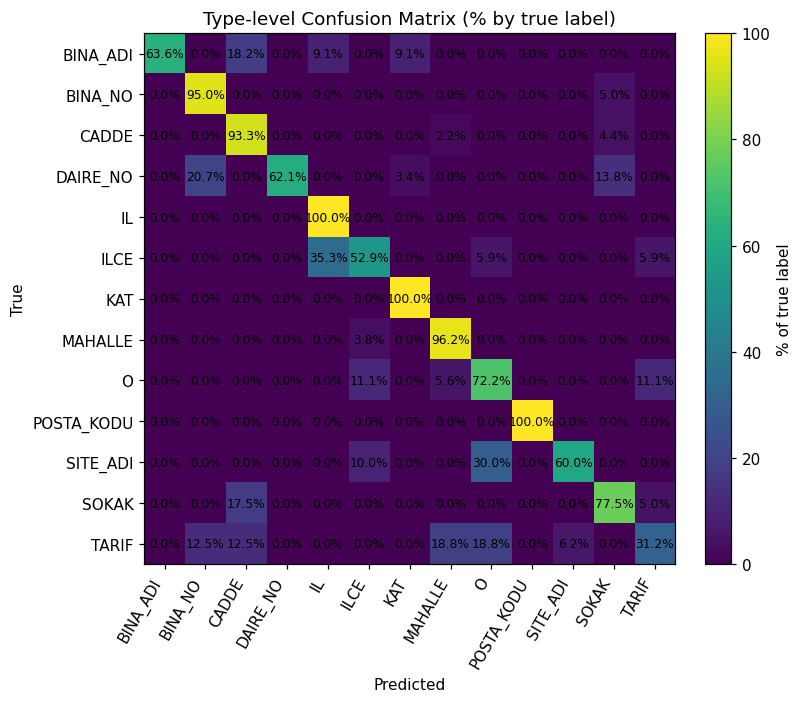


=== TYPE — per-label metrics ===


,precision,recall,f1,accuracy,support
BINA_ADI,1.000000,0.636364,0.777778,0.986667,11
BINA_NO,0.826087,0.950000,0.883721,0.966667,40
CADDE,0.792453,0.933333,0.857143,0.953333,45
DAIRE_NO,1.000000,0.620690,0.765957,0.963333,29
IL,0.611111,1.000000,0.758621,0.976667,11
ILCE,0.642857,0.529412,0.580645,0.956667,17
KAT,0.818182,1.000000,0.900000,0.993333,9
MAHALLE,0.910714,0.962264,0.935780,0.976667,53
O,0.650000,0.722222,0.684211,0.960000,18
POSTA_KODU,1.000000,1.000000,1.000000,1.000000,1



=== TYPE — averages ===


,value
overall_accuracy,0.803333
micro_precision,0.803333
micro_recall,0.803333
micro_f1,0.803333
macro_precision,0.800263
macro_recall,0.772445
macro_f1,0.770705
weighted_precision,0.810175
weighted_recall,0.803333
weighted_f1,0.795072


In [22]:
EVAL_CONLL_PATH = "/content/goldset_1k_yegeb.conll"
res = evaluate_conll_with_metrics(EVAL_CONLL_PATH, pool="mean", max_samples=None, show_plots=True)

print("\n=== TYPE — per-label metrics ==="); display(res["per_label_type"])
print("\n=== TYPE — averages ==="); display(res["averages_type"].to_frame("value"))
